## Modules à importer

In [1]:
import math
import scipy
import pickle
import astropy
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [2]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

In [3]:
d = pd.read_csv('../../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

with open('../../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

def set_cons(cons):
    global df
    
    zmax_cuts = dict()
    z_zcuts = dict()
    x1_zcuts = dict()
    x1_err_zcuts = dict()
    
    names = ['SNF' for i in range(len(surv['SNF']['host.zcmb']))]
    stretchs = list(surv['SNF']['salt2.X1'])
    stretchs_err = list(surv['SNF']['salt2.X1.err'])
    redshifts = list(surv['SNF']['host.zcmb'])
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
    for survey in surveys[1:]:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
        py += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])
        
    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(int_set_cons)

names = ['SNF' for i in range(len(surv['SNF']['host.zcmb'].values))]
stretchs = list(surv['SNF']['salt2.X1'].values)
stretchs_err = list(surv['SNF']['salt2.X1.err'].values)
redshifts = list(surv['SNF']['host.zcmb'].values)
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

interactive(children=(Checkbox(value=False, description='Conservative'), Output()), _dom_classes=('widget-inte…

## Minimisation des modèles à mettre dans le _pandas_

In [4]:
gen = stretchevol.generic()
gen.set_model('Evol1G1M2S')

gen.set_data(df[df['survey'] == 'PS1'])
assymPS1 = gen.fit()

gen.set_data(df[df['survey'] == 'SDSS'])
assymSDSS = gen.fit()

gen.set_data(df[df['survey'] == 'SNLS'])
assymSNLS = gen.fit()

assym = {'SDSS': assymSDSS,
         'PS1': assymPS1,
         'SNLS': assymSNLS}

## Modèle _base_ pour comparaison

In [5]:
gen.set_model('Evol3G2M2SSNF')
gen.set_data(df[df['survey'] == 'SNF'])
base = gen.fit()

### Définition likelihood generic

In [6]:
def assym_law_gen(x, param):
    return(assymPS1.likelihood_tot(x, np.zeros(len(x)), param[0], param[1], param[2]))

# Pantheon dictionnaries

## Définition de _cov_ pour sélection aléatoire des paramètres

In [8]:
cov = dict()
mean = dict()
param_hesse_mat = dict()
models_hesse = dict()
models_std = dict()

p_sco = {'SDSS': [1.142, 1.652, 0.104],
         'PS1': [0.384, 0.987, 0.505],
         'SNLS': [0.974, 1.236, 0.283]}

xlin = np.linspace(-3, 3, 3000)

for survey in surveys[1:-1]:
    cov[survey] = im.Minuit.matrix(assym[survey].m_tot)
    mean[survey] = [assym[survey].m_tot.values[i] for i in range(3)]
    param_hesse_mat[survey] = scipy.stats.multivariate_normal.rvs(mean=mean[survey], cov=cov[survey], size=500)
    models_hesse[survey] = [assym_law_gen(xlin, param_hesse) for param_hesse in param_hesse_mat[survey]]
    models_hesse[survey] = np.asarray(models_hesse[survey])
    models_std[survey] = np.std(models_hesse[survey], axis=0)

## PDF dict

In [9]:
def pdfS(x):
    return assymSDSS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymSDSS.param['mu'],
                                    assymSDSS.param['sigma_m'],
                                    assymSDSS.param['sigma_p'])

def pdfP(x):
    return assymPS1.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymPS1.param['mu'],
                                    assymPS1.param['sigma_m'],
                                    assymPS1.param['sigma_p'])

def pdfN(x):
    return assymSNLS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymSNLS.param['mu'],
                                    assymSNLS.param['sigma_m'],
                                    assymSNLS.param['sigma_p'])

def pdfS_sco(x):
    return assymSDSS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['SDSS'][0],
                                    p_sco['SDSS'][1],
                                    p_sco['SDSS'][2])

def pdfP_sco(x):
    return assymPS1.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['PS1'][0],
                                    p_sco['PS1'][1],
                                    p_sco['PS1'][2])

def pdfN_sco(x):
    return assymSNLS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['SNLS'][0],
                                    p_sco['SNLS'][1],
                                    p_sco['SNLS'][2])

pdfA = {'SDSS': pdfS,
        'PS1': pdfP,
        'SNLS': pdfN}

pdfA_sco = {'SDSS': pdfS_sco,
            'PS1': pdfP_sco,
            'SNLS': pdfN_sco}

## Tracé

In [10]:
def plot_pdfs(surveyname, color_p="C2", color_s="0.2", perc_zmin=5, perc_zmax=95,
              ticks_size=12, show_legend=False,
              lw_col=2, lw_mod=2, lw_sco=2, ls_col='-', ls_mod='-', ls_sco='--'):
    fig = plt.figure(figsize=[6, 4])
    ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
    
    x_linspace = np.linspace(-3, 3, 3000)
    
    ax.plot(x_linspace,
            pdfA[surveyname](x_linspace),
            color=color_p,
            lw=lw_mod, ls=ls_mod,
            label=surveyname)
    
    ax.fill_between(x_linspace,
                    pdfA[surveyname](x_linspace) + models_std[surveyname],
                    pdfA[surveyname](x_linspace) - models_std[surveyname],
                    color=color_p,
                    lw=1, alpha=.2)
    
    ax.vline(assym[surveyname].param['mu'], ymin=0, ymax=np.max(pdfA[surveyname](x_linspace)),
             color=color_p, alpha=.5, linewidth=2.0)
    
    mu_s = p_sco[surveyname][0]
    sigma_m_s = p_sco[surveyname][1]
    sigma_p_s = p_sco[surveyname][2]
    
    pdf_SCO = assym[surveyname].likelihood_tot(x_linspace,
                                               np.zeros(len(x_linspace)),
                                               mu_s,
                                               sigma_m_s,
                                               sigma_p_s)
    
    ax.plot(x_linspace,
            pdf_SCO,
            color=color_s, label='Scolnic',
            lw=lw_sco, ls=ls_sco)
    
    ax.vline(mu_s, 0, np.max(pdf_SCO),
             color=color_s, alpha=.5, linewidth=2.0)
    
    dgmap = plt.cm.get_cmap('coolwarm')
    nb_base = len(surv[surveyname].zCMB)
    i = 0
    
    z_m, z_p = np.percentile(surv[surveyname].zCMB, [perc_zmin, perc_zmax])
    
    for z in surv[surveyname].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
        pdf = base.likelihood_tot(base.delta(z),
                                  x_linspace, np.zeros(len(x_linspace)),
                                  base.param['aa'],
                                  base.param['mu_1'], base.param['sigma_1'],
                                  base.param['mu_2'], base.param['sigma_2'])
    
        ax.plot(x_linspace,
                np.max(pdfA[surveyname](x_linspace))/np.max(pdf)*pdf,
                color=dgmap((z-z_m)/(z_p-z_m)), alpha=.15,
                lw=lw_col, ls=ls_col)
        i += 1
     
    ax.set_xlim([-3, 3])
    ax.set_ylim([0, np.max(pdfA[surveyname](x_linspace)+models_std[surveyname])+0.01])
                                                                          
    ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
    ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')
    
    ax.tick_params(labelsize=ticks_size)
    
    if show_legend:
        ax.legend(ncol=1, loc='upper right')
    
    return(fig)

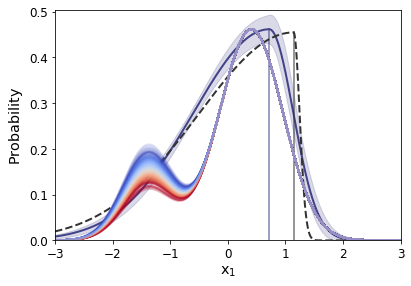

In [11]:
surveyname = 'SDSS'
fig = plot_pdfs(surveyname, color_p=colors[surveyname], ticks_size=12)
path = '../../../Images/bbc_comp_' + surveyname + '.pdf'
fig.savefig(path, bbox_inches='tight')

# Associated graphs

## Functions definitions

In [12]:
with open('../Data/ALL_results', 'rb') as f:
    res_ALL = pickle.load(f)

def age_law_all(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*res_ALL['mu_1']
      + (1-delta(z))*(base.get_a(res_ALL['aa'])*res_ALL['mu_1']
                      + (1 - base.get_a(res_ALL['aa']))*res_ALL['mu_2']))

with open('../Data/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

def age_law_snf(z):
    """Analytical law with snf results"""
    return (delta(z)*res_SNF['mu_1'] +
        (1-delta(z))*(base.get_a(res_SNF['aa'])*res_SNF['mu_1']
                      + (1-base.get_a(res_SNF['aa']))*res_SNF['mu_2']))

def delta(z):
    return stretchevol.MockEvol().delta(z)

## xmean definitions

In [13]:
z_linspace = np.linspace(0, 1.4, 3000)
x_linspace = np.linspace(-10, 10, 1e7)

xmean_asym = dict()
xmean_asym_sco = dict()

for survey in surveys[1:-1]:
    xmean_asym[survey] = np.sum(x_linspace*pdfA[survey](x_linspace))/np.sum(pdfA[survey](x_linspace)) 
    xmean_asym_sco[survey] = np.sum(x_linspace*pdfA_sco[survey](x_linspace))/np.sum(pdfA_sco[survey](x_linspace)) 

## Simple BBC-stretchevol

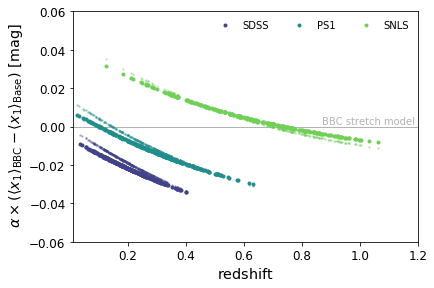

In [17]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

alpha = 0.156

for survey in surveys[1:-1]:
    ax.plot(df_full[df_full['survey'] == survey].redshifts,
            alpha*(xmean_asym_sco[survey] - age_law_snf(df_full[df_full['survey'] == survey].redshifts)),
            color=colors[survey], lw=2, ls='None', marker='.', alpha=.3, ms=3, zorder=6)
    
    ax.plot(df_full[df_full['survey'] == survey].redshifts,    
            alpha*(xmean_asym_sco[survey] - age_law_all(df_full[df_full['survey'] == survey].redshifts)),    
            color=colors[survey], lw=2, ls='None', marker='.',    
            label=survey, zorder=6)
    
ax.hline(0, zorder=2, color="0.7", lw=1)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r" $\alpha\times\left(\langle x_1 \rangle_{\mathrm{BBC}} - \langle x_1 \rangle_{\mathrm{Base}}\right)$ [mag] ", fontsize="x-large")

#ax.set_ylim(-0.52, 0.52)
ax.set_ylim(-0.06, 0.06)
ax.set_xlim(0.01, 1.2)
#ax.set_xscale('log')

ax.legend(ncol=3, loc='upper right', frameon=False)

ax.tick_params(labelsize=12)

ax.text(0.99, 0.5, 'BBC stretch model',
        va='bottom', ha='right', transform=ax.transAxes,
        color='0.7')

fig.savefig('../../../Images/BBC_-stretchevol.pdf', bbox_inches='tight')

## Combined bins definitions

In [15]:
df_bias = df_full[df_full['survey'].isin(['PS1','SDSS','SNLS'])]

def get_bias(df_line, alpha=0.156):
    meanBBC = xmean_asym_sco[df_line.survey]
    meanBASE = age_law_all(df_line.redshifts)
    return(alpha*(meanBBC - meanBASE))

df_bias['bias'] = np.asarray([get_bias(df_bias.iloc[l]) for l in range(len(df_bias))])

z_bin = np.linspace(0, 1.5, 30)
df_bias['zbin'] = np.digitize(df_bias.redshifts, z_bin)

df_bias_grouped = df_bias.groupby('zbin').mean()

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## Advanced BBC-stretchevol + cosmology

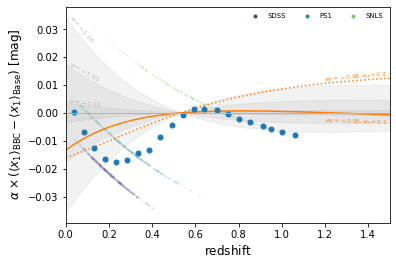

In [16]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])

#ax.plot(df_bias.redshifts,
#        df_bias.bias, ls='None', marker='o')
prop=dict(lw=2, ls='None', marker='.', ms=4, alpha=.1, mew=0)

for survey in surveys[1:-1]:
    ax.plot(df_full[df_full['survey'] == survey].redshifts,    
            alpha*(xmean_asym_sco[survey] - age_law_all(df_full[df_full['survey'] == survey].redshifts)),    
            color=colors[survey], **prop)

zz = 10**np.linspace(-3, 3, 100)
wcdm = astropy.cosmology.FlatwCDM(70, 0.30, w0=-1)
REFZ = 0.5
for w in [[-0.90, -1.10], [-0.95, -1.05],[-0.99, -1.01]]:
    deltaup = wcdm.distmod(zz) -astropy.cosmology.FlatwCDM(70, 0.30, w0=w[0]).distmod(zz)
    deltalow = wcdm.distmod(zz)-astropy.cosmology.FlatwCDM(70, 0.30, w0=w[1]).distmod(zz)
    ax.fill_between(zz,
                    deltaup-deltaup[np.argmin(np.abs(zz-REFZ))],
                    deltalow-deltalow[np.argmin(np.abs(zz-REFZ))],
                    color="0.5", alpha=0.1)

delta_ = wcdm.distmod(zz) -astropy.cosmology.Flatw0waCDM(70, 0.30, w0=-0.95, wa=-0.1).distmod(zz)

ax.plot(zz,
       delta_-delta_[np.argmin(np.abs(zz-REFZ))],
       color='C1')

delta_ = wcdm.distmod(zz) -astropy.cosmology.Flatw0waCDM(70, 0.30, w0=-0.98, wa=0.2).distmod(zz)

ax.plot(zz,
       delta_-delta_[np.argmin(np.abs(zz-REFZ))],
       color='C1', ls=':')

ax.plot(df_bias_grouped.redshifts,
        df_bias_grouped.bias, ls='None', marker='o',
        color='C0', ms=5)

ax.axhline(0, color="0.7", lw=1)
ax.set_xlim(0, 1.5)
#ax.set_xscale("log")

ax.text(0.01, 0.03, r'$w = -1.10$', color="0.7", fontsize='xx-small',
        rotation=-50, va='center', ha='left')
ax.text(0.01, 0.015, r'$w = -1.05$', color="0.7", fontsize='xx-small',
        rotation=-30, va='center', ha='left')
ax.text(0.01, 0.0035, r'$w = -1.01$', color="0.7", fontsize='xx-small',
        rotation=-7, va='center', ha='left')

xmax = ax.get_xlim()[-1]
ax.text(xmax-0.01, 0.013, r'$w_0=-0.98, w_a=0.2$', color="C1", fontsize='xx-small',
        rotation=5, va='center', ha='right')
ax.text(xmax-0.01, -0.003, r'$w_0=-0.95, w_a=0.1$', color="C1", fontsize='xx-small',
        rotation=-2, va='center', ha='right')

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="large")
ax.set_ylabel(r" $\alpha\times\left(\langle x_1 \rangle_{\mathrm{BBC}} - \langle x_1 \rangle_{\mathrm{Base}}\right)$ [mag] ", fontsize="large")

from matplotlib.lines import Line2D

SDSSleg = Line2D([0], [0], color=colors['SDSS'],linewidth=0, marker='.')
PS1leg = Line2D([0], [0], color=colors['PS1'],linewidth=0, marker='.')
SNLSleg = Line2D([0], [0], color=colors['SNLS'],linewidth=0, marker='.')
labels = ['SDSS', 'PS1', 'SNLS']

ax.legend([SDSSleg, PS1leg, SNLSleg], labels,
           ncol=3, loc='upper right', frameon=False, fontsize='x-small')

fig.savefig('../../../Images/BBC_distmod.pdf', bbox_inches='tight')